# <font color='blue'>**EM-алгоритм**</font> 

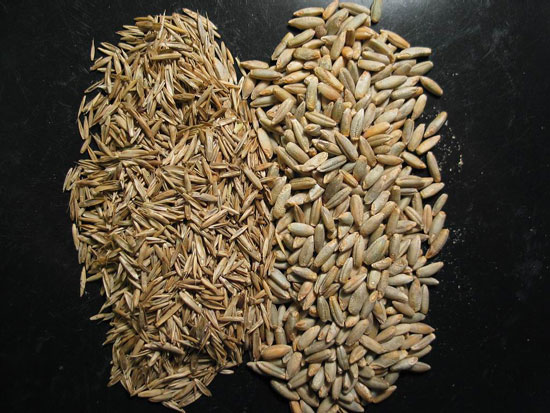

Настало время отделить зёрна от плевел.

# <font color='green'>0. Импорт необходимых модулей</font>  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
import itertools

Зафиксируем сид для генерации

In [2]:
np.random.seed(42)

# <font color='green'>1. Создание гауссовой смеси</font>  

## <font color='green'>1.1 Генерация сэмплов </font>  

Возьмём 1000 точек в 1ой гауссиане, 2000 точек - во 2ой и 3000 точек в 3ьей

In [3]:
n_samples = [1000, 2000, 3000]
n_comp = len(n_samples)
n = sum(n_samples)

Центры и матрицы ковариации гауссиан

In [4]:
mu0 = np.array([-10.0, -10.0])
Cov0 = np.array([[1.0, 0.0], [0.0, 1.0]])

mu1 = np.array([0.0, 0.0])
Cov1 = np.array([[5.0, 0.0], [0.0, 0.5]])

mu2 = np.array([10.0, 0.75])
Cov2 = np.array([[1.0, 0.0], [0.0, 3.0]])

mu = np.array([mu0, mu1, mu2])
Cov = np.array([Cov0, Cov1, Cov2])

Генерируем гауссианы и сразу объединяем их в один numpy-массив

In [5]:
X = np.r_[ 
    np.dot(np.random.randn(n_samples[0], 2), Cov0) + mu0,
    np.dot(np.random.randn(n_samples[1], 2), Cov1) + mu1,
    np.dot(np.random.randn(n_samples[2], 2), Cov2) + mu2,
]

Метки класса для гауссиан

In [6]:
Y = np.zeros(sum(n_samples))
Y[n_samples[0]:n_samples[0]+n_samples[1]] = 1
Y[n_samples[0]+n_samples[1]:] = 2
assert sum(Y == 1) == n_samples[1]
assert sum(Y == 2) == n_samples[2]

## <font color='green'>1.2 Посмотрим на эти гауссианы </font> 

Цвета для гауссиан

In [7]:
colors = ["green", "navy", "darkorange"]

Визуализация

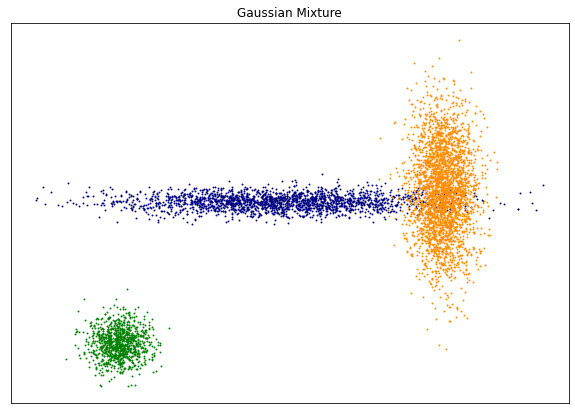

In [8]:
plt.figure(figsize=(10,7))
for i, color in enumerate(colors):
  plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)
plt.xticks(())
plt.yticks(())
plt.title(
    f"Gaussian Mixture"
)
plt.show()

# <font color='green'>2. E-шаг </font>  

Нужно реализовать формулу  $$q(  z_k)  = \frac{\pi_k \mathcal{N} (x \mid \mu_k, \Sigma_k) }{\sum_j \pi_j \mathcal{N} (x \mid \mu_j, \Sigma_j) }$$

Априорные вероятности (1:1:1)

In [9]:
pi = np.ones(n_comp) / n_comp
print(pi)

[0.33333333 0.33333333 0.33333333]


In [10]:
def e_step(X, K, pi, mu, Cov):
    mem = []
    for j in range(K):
        c = 1 / (((2 * np.pi)**(K/2)) * ((np.linalg.det(Cov[j]))**0.5))
        aa = np.exp(-0.5 * (X-mu[j]) @ np.linalg.inv(Cov[j]) @ (X-mu[j]).T)
        
        mem.append(c * np.array(np.diagonal(aa)))
    mem = np.array(mem)

    mem_w = (mem.T * pi).T
    summa = np.sum(mem_w, axis = 0)
    res = mem_w / summa
    
    return res

Проверка

In [11]:
q = e_step(X, n_comp, pi, mu, Cov)
assert q.shape == (n_comp, n)
assert np.allclose(q.sum(axis=0), np.ones(n))

# <font color='green'>3. M-шаг </font>  


 ``Ожидаемая доля точек в $k$-том кластере'': $$ N_k = \sum_{n=1}^N  q(z_{nk}).$$


Новая вероятность попасть в $k$-тый кластер: $$ \pi_k = \frac{N_k}{N}.$$


 Новые средние --- взвешенные среднее данных точек: $$ \mu_k = \frac{1}{N_k} \sum_{n=1}^N q(z_{nk}) x_n. $$

Новые матрицы ковариации: $$ \Sigma_k = \frac{1}{N_k} \sum_{n=1}^N q(z_{nk}) (x_n - \mu_k) (x_n - \mu_k)^T. $$


In [12]:
def m_step(X, K, mu, q):

    pi_new = np.sum(q, axis = 1) / X.shape[0]
    
    mu_new = (np.array((np.matrix(q) * np.matrix(X))).T / np.sum(q, axis = 1)).T
    
    k = np.einsum('ji,kj->jik', X-q.T @ mu, (X-q.T @ mu).T)
    Cov_new = np.einsum('ij,jkl->ikl', q, k)/(pi_new * X.shape[0])[:,np.newaxis,np.newaxis]
    
    return pi_new, mu_new, Cov_new

Проверка

In [13]:
pi, mu, sigma = m_step(X, n_comp,  mu, q)
assert pi.shape == (n_comp,)
assert mu.shape == (n_comp, 2)
assert sigma.shape == (n_comp, 2, 2)

# <font color='green'>4. LogLikelihood </font>  

Нужно реализовать логарифм максимума правдоподобия $$\log p(x \mid \theta) = \sum_{n=1}^N \ln \left[ \sum_{k=1}^K   \pi_k \mathcal{N} ({\color{red} x}_n \mid  \mu_k, \Sigma_k) \right]$$

In [14]:
def LogLikelihood(X, K, pi, mu, sigma):
    mem = []
    for j in range(K):
        c = 1 / (((2 * np.pi)**(K/2)) * ((np.linalg.det(sigma[j]))**0.5))
        aa = np.exp(-0.5 * (X-mu[j]) @ np.linalg.inv(sigma[j]) @ (X-mu[j]).T)
        
        mem.append(c * np.diagonal(aa))
    mem = np.array(mem)

    mem_w = (mem.T * pi).T
    return np.sum(np.log(np.sum(mem_w, axis=0))) 

Вывод функции

In [15]:
LogLikelihood(X, n_comp, pi, mu, sigma)

-33470.371787751465

# <font color='green'>5. Применение алгоритма </font>  

Нужно учесть - *номера кластеров в ответе могут быть переставлены*. 

Поэтому скор - нужно брать максимум угаданных точек для всех перестановок номеров кластеров.

In [16]:
list(itertools.permutations([1, 2, 3]))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

In [17]:
def score(Y_pred, Y_true):
  max_score = []
  for perm in list(itertools.permutations(np.arange(n_comp))):  
    val_perm = np.vectorize(lambda x: perm[int(x)])
    Y_perm = val_perm(Y_true)
    max_score.append(round(accuracy_score(Y_perm, Y_pred), n_comp))
  return max(max_score)

Априорная вероятность

In [18]:
pi = np.ones(n_comp) / n_comp
mu =  np.array([np.mean(X[np.random.choice(len(X), len(X)//n_comp)], axis = 0) for k in range(n_comp)])
sigma = np.array([np.eye(2) for k in range(n_comp)])

## Основной цикл

Итерация №1
Доля правильно распознанных точек 0.474


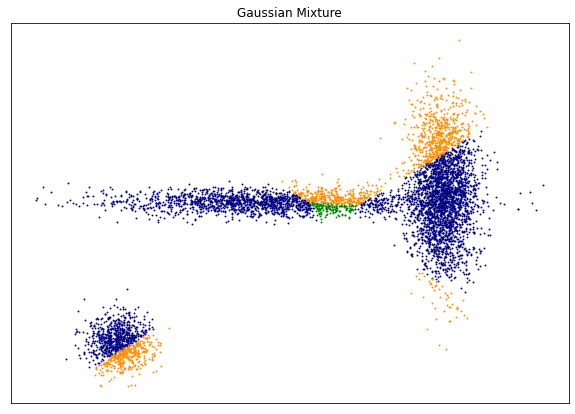

Итерация №2
Доля правильно распознанных точек 0.454


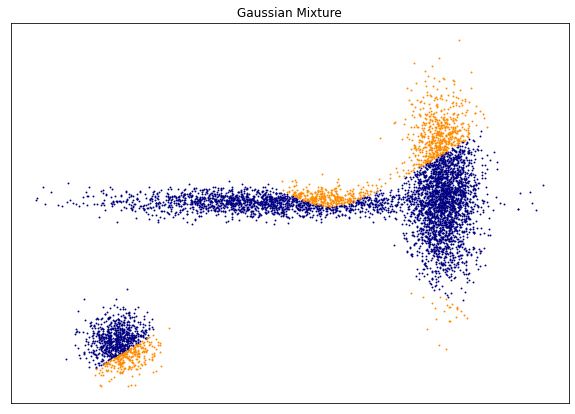

Итерация №3
Доля правильно распознанных точек 0.42


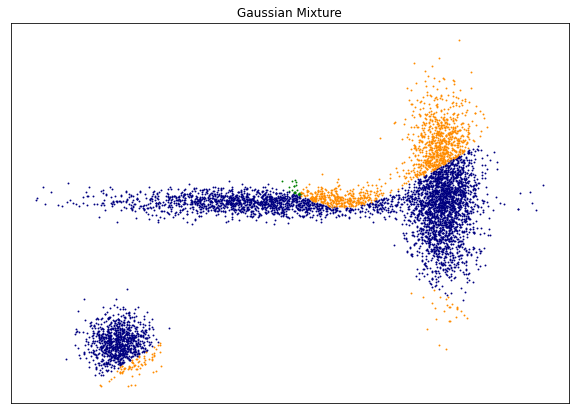

Итерация №4
Доля правильно распознанных точек 0.603


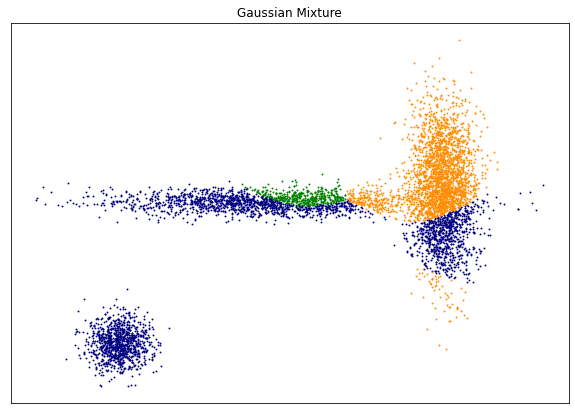

Итерация №5
Доля правильно распознанных точек 0.884


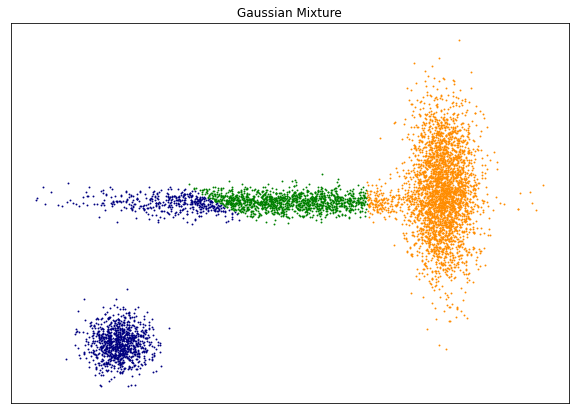

Итерация №6
Доля правильно распознанных точек 0.939


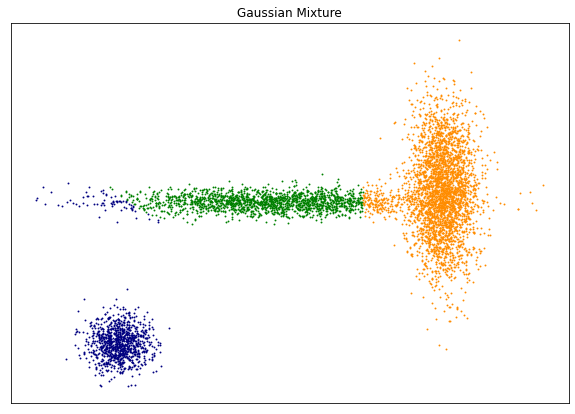

Итерация №7
Доля правильно распознанных точек 0.939


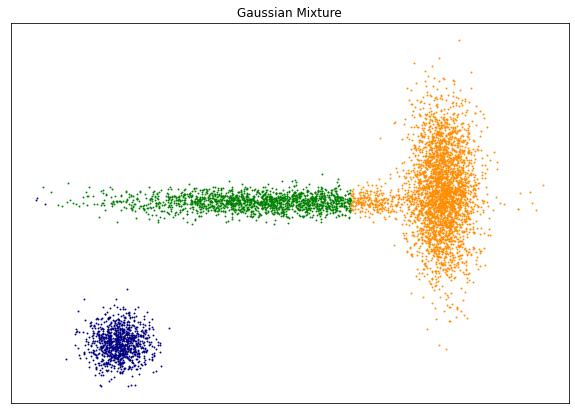

In [19]:
# выберем количество итераций EM-алгоритма
steps = 7
LLS = []
# запустим цикл EM-алгоритма
for i in range(steps):
    # E-step
    proba = e_step(X, n_comp, pi, mu, Cov)
    # M-step
    pi, mu, sigma = m_step(X,  n_comp, mu, proba) 
    # LogLikelihood
    LLS.append(LogLikelihood(X, n_comp, pi, mu, Cov))
    
    Y_ = proba.argmax(axis=0)
   
    print(f'Итерация №{i+1}')
    print(f'Доля правильно распознанных точек {score(Y_, Y)}')    

    # График
    plt.figure(figsize=(10,7))
    for i, color in enumerate(colors):
      plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1],  0.8, color=color)
    plt.xticks(())
    plt.yticks(())
    plt.title(
        f"Gaussian Mixture"
    )
    plt.show()

## LogLikelihood должно возрастать

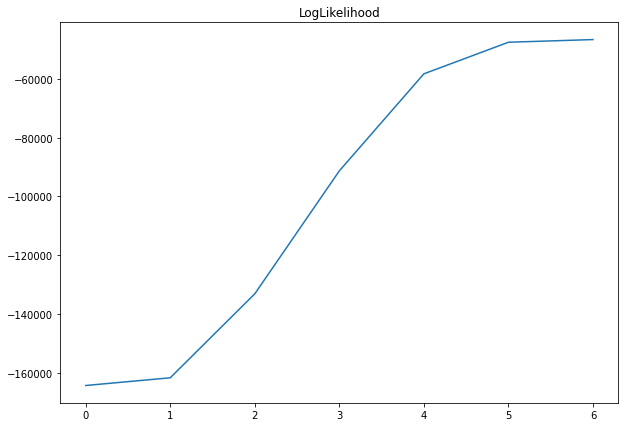

In [20]:
plt.figure(figsize=(10,7))
plt.plot(LLS)
plt.title("LogLikelihood")
plt.show()